In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# From NYC data documentation:

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("h9gi-nx95", limit=20000)   # increase limit to 20,000

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [3]:
df.columns

Index(['crash_date', 'crash_time', 'on_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'location', 'cross_street_name',
       'off_street_name', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'contributing_factor_vehicle_5',
       'vehicle_type_code_5'],
      dtype='object')

In [4]:
df.to_csv("data/api_response.csv", index=False)
df = pd.read_csv("data/api_response.csv", parse_dates = ["crash_date"])

In [5]:
# add a column for the number of contributing factors
df["n_contributing_factors"] = (~df[["contributing_factor_vehicle_1","contributing_factor_vehicle_2","contributing_factor_vehicle_3","contributing_factor_vehicle_4","contributing_factor_vehicle_5"]].isna()).sum(axis=1)

# add column 1=injuries occured, 0=no injuries occured
df["injuries_occured"] = (df["number_of_persons_injured"] > 0).astype(int)

df["death_occured"] = (df["number_of_persons_killed"] > 0).astype(int)

df["injuries_occured"].value_counts(normalize=True)

0    0.67975
1    0.32025
Name: injuries_occured, dtype: float64

# Figure 1: Descriptive Stats

/home/anushka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


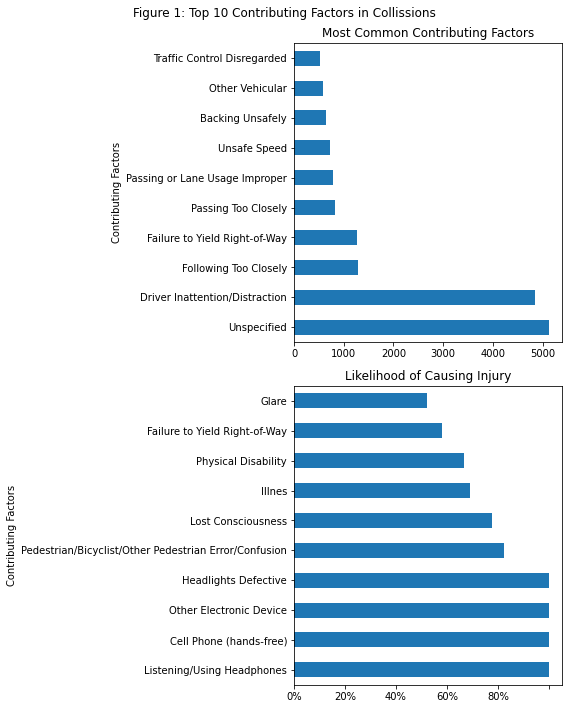

In [16]:
fig, ax = plt.subplots(2,1, figsize=(8,10))

df = df[df["contributing_factor_vehicle_1"] != "80"]

df.groupby(["contributing_factor_vehicle_1"])["collision_id"].count().sort_values(ascending=False)[:10].plot.barh(ax= ax[0])
df.groupby(["contributing_factor_vehicle_1"])["injuries_occured"].mean().sort_values(ascending=False)[:10].plot.barh(ax=ax[1])

for i in range(2):
    ax[i].set_ylabel("Contributing Factors")

ax[1].set_xticklabels([f"{p}%" for p in range(0,100,20)])
    
fig.suptitle("Figure 1: Top 10 Contributing Factors in Collissions")
ax[0].set_title("Most Common Contributing Factors")
ax[1].set_title("Likelihood of Causing Injury")

plt.tight_layout()

# Figure 2: Unsupervised ML

In [7]:
# store features
features = ['number_of_persons_injured', 'number_of_persons_killed',
               'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
               'number_of_cyclist_injured', 'number_of_cyclist_killed',
                'number_of_motorist_injured', 'number_of_motorist_killed',
           'n_contributing_factors',]

dummies = []

df["day_minutes"] = df["crash_time"].str.split(":").str[0].astype(int) * 60 + df["crash_time"].str.split(":").str[1].astype(int)

features.append("day_minutes")
df["day_name"] = df["crash_date"].dt.day_name()
dummies.append("day_name")

In [8]:
# Generate Feature matrix
X = df[features].fillna(0)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

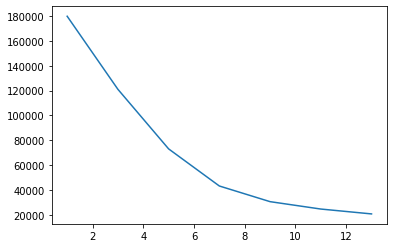

In [9]:
# clustering with kmeans

inertias = []
for k in range(1,14,2): #try cluster numbers 1 to 13 by twos
    inertias.append(KMeans(n_clusters=k).fit(X_scaled).inertia_)
    
plt.plot(range(1,14,2), inertias)

In [10]:
# the above plot indicates 7-9 clusters is reasonable. Select 7 clusters
# use the best k for clustering:
best_k = 7
km = KMeans(n_clusters = best_k).fit(X)
X["cluster_label"] = km.labels_

Text(0.5, 0.98, 'Figure 2: Number of people injured vs. Time passed')

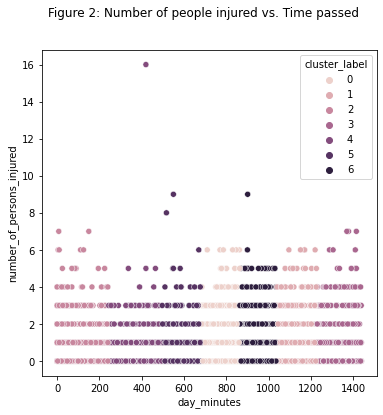

In [11]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=X, x="day_minutes", y="number_of_persons_injured", hue="cluster_label")
plt.suptitle("Figure 2: Number of people injured vs. Time passed")

# Figure 3: Supervised ML

In [12]:
# store features
features = [  "contributing_factor_vehicle_1", 'borough', 'borough', 'n_contributing_factors']
dummies = ["contributing_factor_vehicle_1", 'borough']

In [13]:
X = df[features]
X = pd.get_dummies(X, columns=dummies, prefix="").fillna(0)

y = df["injuries_occured"]

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1, stratify=y)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [14]:
clf = RandomForestClassifier().fit(x_train, y_train)
clf.score(x_test,y_test)

0.7035

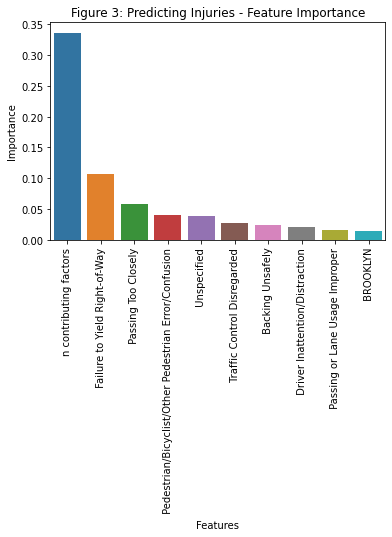

In [15]:
importances = pd.DataFrame([clf.feature_importances_], columns = X.columns, index=["importance"]).T.reset_index()
importances["index"] = importances["index"].str.replace("_"," ")
importances = importances.sort_values("importance", ascending=False)
sns.barplot(data=importances[:10], x="index" , y="importance")
plt.title("Figure 3: Predicting Injuries - Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90);